# Math Dataset Training sample

> You can contact me on twitter as [@mandubian](http://twitter.com/mandubian)

This notebook demonstrates a Pytorch training of a Multi-Head Self-Attention Transformer model on Mathematical Reasoning Dataset v1.0 as explained in this very cool paper:

> Analysing Mathematical Reasoning Abilities of Neural Models
>
> David Saxton, Edward Grefenstette, Felix Hill, Pushmeet Kohli
>
> (Submitted on 2 Apr 2019)
>
>http://arxiv.org/abs/1904.01557

**On top of paper, the current project provides a few Numpy/Pytorch helpers to manipulate Mathematical Reasoning Dataset in a simpler way and train very fast different kinds of models on it. Without loading everything in memory, it tries to manage data in a streamed and lazy-loading way (as much as Python allows it).**

The idea of the paper is to provide a robust toolkit (https://github.com/deepmind/mathematics_dataset) to randomly and heterogenously generate mathematical datasets among multiple math problem categories:
    - algebra
    - numbers
    - polynomials
    - arithmetic
    - measurement
    - comparison
    - probability
    - calculus
    
All problem are constituted of a textual question like `what is 30 + 535?` (max 160 chars) and a textual response `565` (max 30 chars). So it's not an abstract representation of math problem but a very human one and it mixes Natural Language Processing with math concepts.

For each of those categories, it provides multiple operation modules. For ex, in `algebra` category:
    - mul
    - add_or_sub_in_base
    - simplify_surd
    - mul_div_multiple
    - mixed
    - nearest_integer_root
    - div
    - add_or_sub
    - add_sub_multiple
    - add_sub_multiple_longer
    - mul_div_multiple_longer
    - div_big
    - mul_big
    - mixed_longer
    - add_or_sub_big

Problem can be generated with different difficulties:
    - train-easy
    - train-medium
    - train-hard

It also provides test datasets for `interpolation` tests mixing all kinds of problem per category and `extrapolation` tests to measure generalization capabilities of models.

>An implementation of dataset generator is provided at >https://github.com/deepmind/mathematics_dataset and a v1.0 of the dataset is >available there


The main purpose of this dataset generator is to provide a playground to people who want to study how neural networks can learn to solve mathematical problems or even better learn math abstractions.


In [1]:
#!pip install --user tensorboardX
#!pip install --user --force https://github.com/chengs/tqdm/archive/colab.zip

In [7]:
import math
import numpy as np
import torch
from torch.utils import data
import torch.optim as optim

import math_dataset
from math_dataset import MathDatasetManager

from transformer.Models import Transformer
from math_dataset import (
    random_split_dataset,
    question_answer_to_position_batch_collate_fn
)
import model_process
import utils
from tensorboard_utils import Tensorboard
from tensorboard_utils import tensorboard_event_accumulator

import checkpoints

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook  

print("Torch Version", torch.__version__)

%load_ext autoreload
%autoreload 2

Torch Version 1.4.0


## Math Dataset Manager

This class is just a Numpy/Pytorch helper to manage all files in Math Dataset v1.0 and select different parts of it by categories or modules to generate a Pytorch dataset for training. Pytorch Datasets created doesn't mount all questions/answers in memory and use Pandas limited streaming features to bufferize data. It allows loading huge files quite fast while keeping memory print reasonable. It also caches lazy datasets and allows fast re-using previously created ones.

Here are the main features provided right now.

### Initialize Math Dataset Manager

In [8]:
mdsmgr = MathDatasetManager(
  "C:\\Users\\Jesús\\Documents\\PC2\\TorchDemo\\hs-math-nlp\\mathematics_dataset-v1.0\\mathematics_dataset-v1.0\\"
)

initialized MultiFilesMathDataset with categories ['algebra', 'arithmetic', 'calculus', 'comparison', 'measurement', 'numbers', 'polynomials', 'probability'] and types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


### Check availables types (difficulties + interpolate + extrapolate)

In [9]:
print("types", list(mdsmgr.get_types()))

types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


### Check availables problem categories

In [10]:
print("categories", list(mdsmgr.get_categories()))

categories ['algebra', 'arithmetic', 'calculus', 'comparison', 'measurement', 'numbers', 'polynomials', 'probability']


### Check availables modules for a problem category

In [5]:
print("modules of arithmetic", mdsmgr.get_modules_for_category('arithmetic'))

modules of arithmetic dict_keys(['add_or_sub', 'add_or_sub_in_base', 'add_sub_multiple', 'div', 'mixed', 'mul', 'mul_div_multiple', 'nearest_integer_root', 'simplify_surd', 'add_or_sub_big', 'add_sub_multiple_longer', 'div_big', 'mixed_longer', 'mul_big', 'mul_div_multiple_longer'])


### Build Dataset from a single module in a category

In [6]:
ds = mdsmgr.build_dataset_from_module('arithmetic', 'add_or_sub', 'train-easy')
print("size", len(ds))

size 666666


c:\Users\Jesús\Documents\PC2\TorchDemo\venv\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Build Dataset from a single module in a category with limited number of elements

In [7]:
ds2 = mdsmgr.build_dataset_from_module('arithmetic', 'add_or_sub', 'train-easy', max_elements=1000)
print("size", len(ds))

ValueError: Attempting to build dataset twice

### Build Dataset from several modules in a category

In [9]:
ds = mdsmgr.build_dataset_from_modules('arithmetic', ['add_or_sub', 'add_sub_multiple'], 'train-easy')
print("size", len(ds))

ValueError: Attempting to build dataset twice

### Build Dataset from all modules in a category

In [ ]:
ds = mdsmgr.build_dataset_from_category('arithmetic', 'train-easy')
print("size", len(ds))

### Build Dataset from all modules in several categories

In [ ]:
ds = mdsmgr.build_dataset_from_categories(['arithmetic', 'polynomials'], 'train-easy')
print("size", len(ds))

## Pytorch Initialization

In [11]:
seed = 1
torch.manual_seed(seed)
device = torch.device("cuda")
print("device", device)

device cuda


## Train on Algebra Linear_1d in Easy mode

### Create an experiment with a name and a unique ID

In [12]:
exp_name = "linear_algebra_2011" # "math_ds_algebra_linear_1d_easy"
unique_id = "2021-07-24" # "2019-05-25_0900"

### Build Dataset for training

#### Train-easy dataset

In [13]:
ds = mdsmgr.build_dataset_from_module(
    'algebra', 'linear_1d', 'train-easy', 1000
)
print("train-easy dataset size", len(ds))

train-easy dataset size 1000


C:\Users\Jesús\Documents\PC2\TorchDemo\hs-math-nlp\torch\lib\site-packages\pandas\core\frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Interpolate dataset

In [14]:
ds_interpolate = mdsmgr.build_dataset_from_module(
    'algebra', 'linear_1d', 'interpolate', 1000
)
print("interpolate dataset size", len(ds_interpolate))

interpolate dataset size 1000


### Create default Transformer model

Here we test the best model found in the paper: a multi-head self-attention transformer to give a default sample.


In [15]:
model = utils.build_transformer()

### Create basic optimizer

In [16]:
optimizer = optim.Adam(model.parameters(), lr=6e-6, betas=(0.9, 0.995), eps=1e-9)

### Create Pytorch dataloaders

In [17]:
# here we split data in 90/10% for train/validation and use interpolate for test
train_ds, val_ds = math_dataset.random_split_dataset(ds, split_rate=0.9)

# we provide the function question_answer_to_position_batch_collate_fn that collates
# all questions/answers into transformer format enhanced with char positioning
train_loader = data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=8,
    collate_fn=question_answer_to_position_batch_collate_fn)

val_loader = data.DataLoader(
    val_ds, batch_size=128, shuffle=False, num_workers=8,
    collate_fn=question_answer_to_position_batch_collate_fn)

interpolate_loader = data.DataLoader(
    ds_interpolate, batch_size=128, shuffle=False, num_workers=8,
    collate_fn=question_answer_to_position_batch_collate_fn)


In [18]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [19]:
if not isinstance( train_loader.dataset ,torch.utils.data.dataset.Subset):
    print ("-"*30)

### Create Tensorboard metrics logger

In [20]:
tb = Tensorboard(exp_name, unique_name=unique_id)

Writing TensorBoard events locally to runs\linear_algebra_2011_2021-07-24


In [21]:
model = model.to(device)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 12: invalid start byte

In [17]:
#model_process.train(
#    name=exp_name +"_" + unique_id,
#    model=model, 
#    training_data=train_loader, validation_data=val_loader, interpolate_data=interpolate_loader,
#    optimizer=optimizer, device=device,
#    epochs=20, tb=tb, log_interval=100,
#)

model_process.train(
    name = exp_name +"-" + unique_id,
    model = model,
    training_data= train_loader,
    validation_data = val_loader,
    interpolate_data=interpolate_loader,
    optimizer = optimizer,
    device = device,
    epochs=8,
    tb=tb,
    log_interval=100)

~~~ Beginning Training ~~~~
Start epoch: 0, Start batch: 0, Max batch: None
[ Epoch: 0 / 8, Run Batch: 0 / None]


BrokenPipeError: [Errno 32] Broken pipe

### Plotting Training from Tensorboard data

#### Restore best model for this experience

In [19]:
# build default transformer model
model = utils.build_transformer()

model_exp_name = "linear_algebra" # "math_ds_algebra_linear_1d_easy"
model_unique_id  = "2020-07-22" # "2019-05-25_0900"
#model_exp_name = 'math_ds_algebra_linear_1d_easy'
#model_unique_id = '2019-10-27_2300'
# restore best validation model from checkpoint
_ = checkpoints.restore_checkpoint(".\\checkpoints\\linear_algebra_2020-07-22_4688_training_best.pth","", model=model)


Attempting to extract state from .\checkpoints\linear_algebra_2020-07-22_4688_training_best.pth...
Loading model state_dict from state found in .\checkpoints\linear_algebra_2020-07-22_4688_training_best.pth


#### Loading tensorboard events

In [21]:
valid_ea = tensorboard_event_accumulator(
    "./runs/math_ds_algebra_linear_1d_easy_2019-05-25_0900_eval/events.out.tfevents.1556176200.c77692173f6a"
)

interpolate_ea = tensorboard_event_accumulator(
    "./runs/linear_algebra_2020-07-22_interpolate/events.out.tfevents.1556176208.c77692173f6a"
)


NotFoundError: b'./runs/math_ds_algebra_linear_1d_easy_2019-05-25_0900_eval/events.out.tfevents.1556176200.c77692173f6a' does not point to valid Events file

In [20]:
valid_accuracy = valid_ea.Scalars("epoch/accuracy")
valid_loss_per_char = valid_ea.Scalars("epoch/loss_per_char")

interpolate_accuracy = interpolate_ea.Scalars("epoch/accuracy")
interpolate_loss_per_char = interpolate_ea.Scalars("epoch/loss_per_char")


NameError: name 'valid_ea' is not defined

#### Plot loss per char


<IPython.core.display.Javascript object>


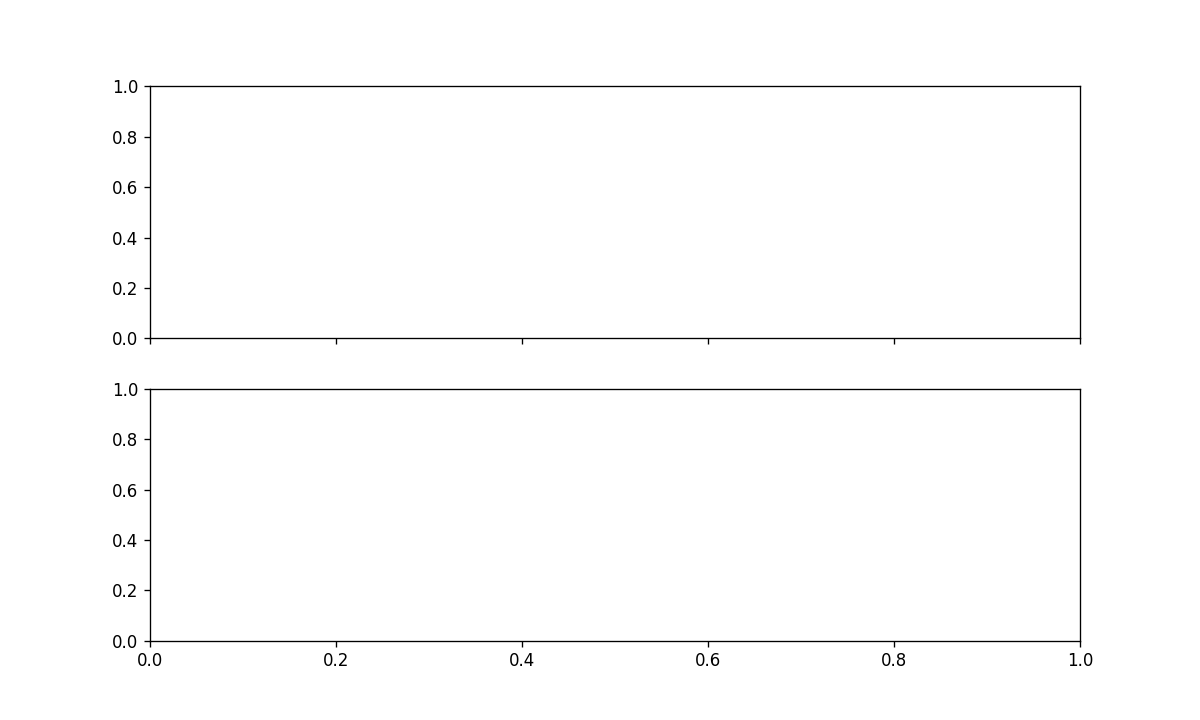

NameError: name 'valid_loss_per_char' is not defined

In [20]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(
    list(map(lambda l: l.step, valid_loss_per_char)),
    list(map(lambda l: l.value, valid_loss_per_char)),
    marker='+', label='Validation Loss per Char'
)
ax2.plot(
    list(map(lambda l: l.step, interpolate_loss_per_char)),
    list(map(lambda l: l.value, interpolate_loss_per_char)),
    marker='+', label='Interpolate Loss per Char', color="orange"
)
plt.title('Algebra/Linear_1d Loss per Char')
ax1.legend(loc='upper left', frameon=False)
ax2.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 20, step=1.0))
#plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()


> As we can see, loss per char on validation dataset has a nice optimization curve but for interpolate, it's not the case. It's quite normal, interpolate contains more difficult and general cases. 

#### Accuracy Evolution during training

<IPython.core.display.Javascript object>


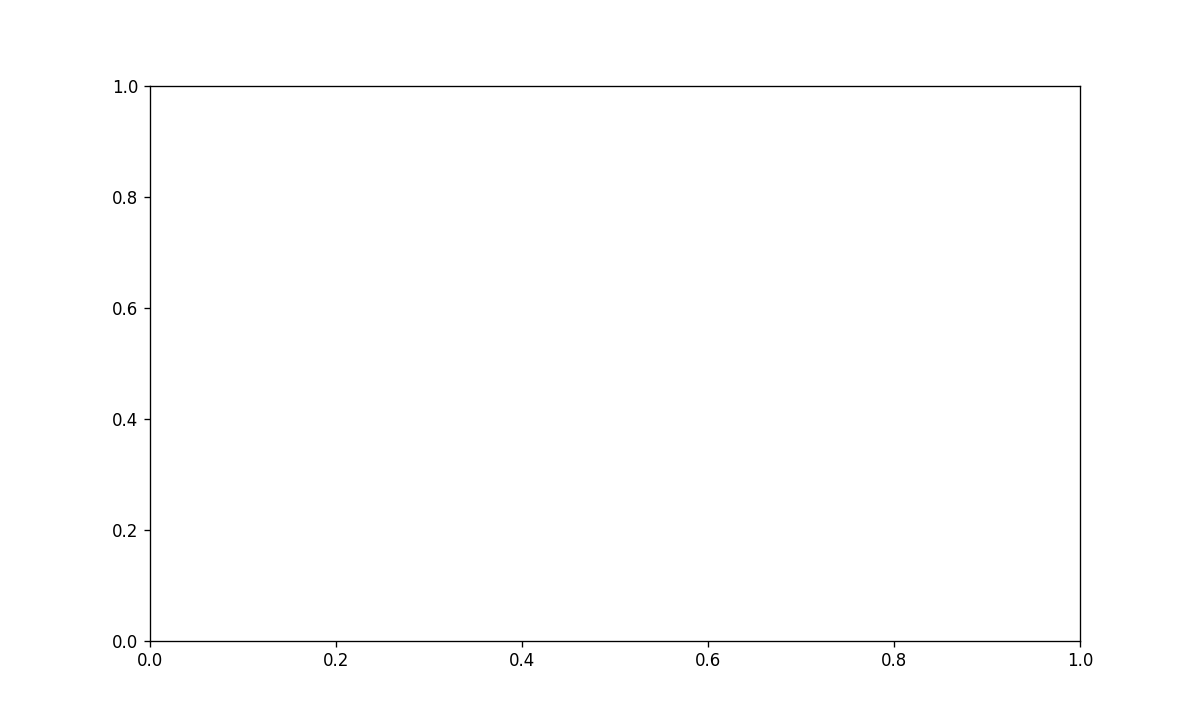

NameError: name 'valid_accuracy' is not defined

In [21]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

ax.plot(
    list(map(lambda l: l.step, valid_accuracy)),
    list(map(lambda l: l.value, valid_accuracy)),
    marker='+', label='Validation Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, interpolate_accuracy)),
    list(map(lambda l: l.value, interpolate_accuracy)),
    marker='+', label='Interpolate Accuracy'
)
plt.title('Algebra/Linear_1d Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 20, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()


> Accuracy for validation dataset is growing constantly up to 85% while for interpolate dataset, it doesn't change much. Interpolate dataset contains too complicated and generic problems compared to training set.

### Test Model

In [22]:
model_process.predict_single("Solve 5 * d = 20 for d.", model, device, n_best=1)


IndexError: tensors used as indices must be long, byte or bool tensors